This Jupyter notebook is a property of the University of California and copyrighted by Dipak Ghosal. Only personal use for ECS 132 and ECS 256 classes is allowed. Uploading this to any shared site is a violation of the University of California copyright laws

# A Project on Covert Timing Channels

## Instructions

    1. You may in no circumstances upload this project to private tutoring websites such as CourseHero or Chegg. Remember all material related to this course  is a property of the University of California and posting them is a violation of the copyright laws and will lead to serious consequences. 
    
    2. In doing this project if you refer to a source (either a book or the internet), you must cite it.
    
    3. You are highly urged to work on this project on your own.  If you do discuss with others,  you must list their names. 
    
    4. This Jupyter Notebook requires Python 3 ipykernel. You  must write your code in Python 3. Make sure to run this notebook under the Python kernel.

## 1. Introduction
The goal of this project is to learn about how to design, detect, and implement a covert timing channel using a stream of packets generated by an application.  We will do this project in steps.  The remainder of this document is organized as follows.

[Background](#2-background)

## 2. Background

Covert communication is method of exchanging secret messages in which the communication is hidden. A related term is steganography which  deals with methods  to write/embed hidden messages in such a way that no one, other than the sender and the intended receiver, know the existence of the message. The word steganography is of Greek origin and means "concealed writing" from the Greek words steganos meaning "covered or protected", and graphei meaning "writing" [From Wikipedia]. Steganography and covert channels have a long history and was used  in WWII to send secret messages to spies behind enemy lines. In computer and network security, covert channels and steganography  fall in the broad category of **security through obscurity**.

The advantage of a covert channel over cryptography is that messages do not attract attention to themselves. Plainly visible encrypted messages — no matter how unbreakable — will arouse suspicion. The very presence of encrypted messages may be incriminating in countries where encryption is illegal. In such cases the communication channel must itself be hidden and this is achieved using covert channels/steganography. Note that, cryptography protects the contents of a message. Covert communication on the other hand attempts protects both the message and the communicating parties.

Typically, steganography refers to the concealment of information within a document file, image file, or program. Media files are ideal for steganographic transmission because of their large size. As a simple example, a sender might start with an innocuous image file and adjust the color of every 100th pixel to correspond to a letter in the alphabet. The overall change is so small  that someone not specifically looking for it is unlikely to notice it. Another method is called the Least Significant Bit (LSB) substitution. In this method, the least significant bit of each  pixel in a digital image is modified by the bits  of the secret message. Since the LSB contributes very little to the overall (intensity/color/brightness) of each pixel, the change in the image will be imperceptible to the naked eye.

Covert channels are communication channels that are established over some overt medium. For example, we can uses a stream of network packets (for example stream of packets generated by a Skype call) as the overt carrier for a covert communication channel. As usual, we have our three characters Alice, Bob, and Eve. Alice and Bob live in a repressive country where all communication is monitored by a warden (Eve). Alice and Bob want to establish a covert channel to exchange secret messages which are sequences of binary digits 0 and 1. Eve can look at all network packets and try to detect if any covert communication is being used to plan a uprising against the repressive state.

To setup a covert communication channel, Alice and Bob first initiate an overt application let say a (computer to computer) Skype call and they start a regular innocuous conversation. Their interactive conversation produces a stream of IP packets from Alice to Bob and Bob to Alice.  For the time being let us only consider covert channel in one direction from Alice to Bob and hence only consider the IP packets stream from Alice to Bob. 

There are two ways in which Alice can send a secret message. She can replace some unused bits in the protocol header with the bits of the covert message. This is called a **covert storage channel**. These types of channels are easily detectable since the protocol header fields that are not used are well known to Eve and she can check bits to detect the covert channel, identify Alice and Bob and the covert message. The other method that Alice can uses is to alter the inter-packet delays of the IP packets, i.e., alter the time between the IP packets. This is called a **covert timing channel** and will be the focus of our study.  

## 3. A Concrete Example

Lets consider a concrete example. For simplicity, we will assume that Alice and Bob are using an application (Skype call) that generates packets in both directions.   Let's consider the packets that are generated by Alice and sent to Bob.  

Each packet has two attributes 1) a sequence number and 2) the time when the packet was generated. Thus, P(n, tn) denotes packet n which was generated at time tn. We will assume that the first packet is numbered 1 and is generated at  time 0, i.e.,  t1 = 0. Note that the time field gives the cumulative time. To obtain the inter-packet delay, we can take the time difference between the consecutive packets.  This packet stream is called the overt traffic. 

In the following discussion we  will assume that  Alice has buffered (stored) a number of packets generated by the application and she can release the packets to send to Bob following some method she and Bob has decided. 

Alice and Bob have *a priori* decided that an inter-packet delay of 0.5 ms  will  be used to code bit 1 and an inter-packet delay of 0.1 ms will be used to code a bit 0. So if Alice wants to code the character “b” (which is 0110 0010) she will release packets from the buffer in the following sequence: P(1, T1), P(2, T2=T1+0.1), P(3, T3=T2+0.5), P(4, T4 = T3+0.1), P(5, T5 = T4+0.1) for the first 4 bits starting from the LSB.  This  is shown in the Figure below. 

The packet stream generated by Alice that encodes the secret message in the inter-packet delays is called the covert traffic. 

<figure> 
    <img src="Figures/Timing-Channel-Example.jpg" width="800" height="600">
    <figcaption align = "center"><b>Figure - A very simplistic timing channel </b></figcaption>
</figure>


If the timing between the packets are not altered by the network or by Eve, then Bob will observe  the inter-packet a delay of 0.1 ms (between P1 and P2), 0.5 ms (between P2 and P3), 0.1 ms (between P3 and P4), 0.1 ms (between P4 and P5). Bob can translate them to binary  bits 0010 and thus retrieve the first 4 bits of the character "b".  


In this project, we will try to design a method of coding the bits into inter-packet delays such that Eve is not able to discover the covert communication channel. We will assume that the network or Eve will not modify the inter-packet delays.

## 4.  A First Simple Design

Alice ad Bob are having a Skype call. When Alice talks, the Skype application generates a sequence of packets. This is  the overt traffic (also referred to as the overt packet stream). In her computer Alice stores a bunch of the packets (as many as required to send the secret message) in  memory. Then using a specially designed packet scheduler releases the packets one at a time following an encoding scheme that maps bits 0 and 1 to inter-packet delays.  The overall system in Alice's computer is shown in the Figure below.  In this part of the project we  will consider a few simple scheme for encoding a secret message in the inter-packet delays. 

<figure> 
    <img src="Figures/Timing-Channel-Alice.jpg" width="800" height="600">
    <figcaption align = "center"><b>Figure showing the setup in Alice's computer. The overt stream of packets is generated by the Skype application. The inter-packet delays has some (given)  random distribution. The covert packet stream is generated by the packet scheduler. The inter-packet delays are chosen such that they encode the secret message.  </b></figcaption>
</figure>



### 4.1 Secret Message 

The secret message that Alice wants to send to Bob  is \``this is a secret message\''  The characters are encoded using 8 bits ASCII. Write a code to convert  the secret message into a sequence of bits. Include the spaces as well but not the end quotes. You can use the bin and ord  functions as shown below.  

In [ ]:
bin(ord("t"))

'0b1110100'

You can remove the 'b' 

In [ ]:
bin(ord("t")).replace('b','')

'01110100'

1. Include the code that generates the bit sequence corresponding to the secret message. Your code should generate a sequence of binary bits corresponding to the secret message. Also write it  in a file named "secret_message_bits" one bit per line. Put the code in a new cell below. 

In [ ]:
thong_diep = "this is a secret message"
# Ban đầu chuỗi này rỗng, ta sẽ thêm các bit vào đây
chuoi_bit = ""

for ky_tu in thong_diep:
    # Lấy giá trị ASCII của ký tự (ví dụ: 't' là 116)
    gia_tri_ascii = ord(ky_tu)
    
    nhi_phan = bin(gia_tri_ascii).replace('b', '')
    
    nhi_phan = nhi_phan.zfill(8)
    
    # Thêm 8 bit này vào chuỗi bit
    chuoi_bit += nhi_phan

with open("secret_message_bits", "w") as file:
    for bit in chuoi_bit:
        file.write(bit + "\n")

### 4.2 Obtaining the Baseline

We assume that we have a sample of packets that was generated by Skype when Alice and Bob were 
talking without exchanging any secret message. This is the baseline data that is available to Alice and Bob and also to Eve. For this part of the project we will consider the packet stream that is given in the  excel file as the baseline data.  The name of the file is Traffic_data_origin.csv. You  will find the file in the Data sub-folder in the Notebooks folder. The data contains packet numbers and the times when the packets were generated. 


Note that Alice will encode the bits of the secret message by modifying  inter-packet delays. Also,  Eve will will look  into the inter-packet delays, specifically, the distribution (histogram) of the inter-packet delays  to detect any covert communication between Alice and Bob. 

Given the above, let's review Alice's goal and Eve's task. 

1. Alice's Goal: Alice ofcourse knows the distribution of the inter-packet delay of the baseline. Again baseline means when Bob and she and Bob communicate without exchanging any secret message. When she wants to send a secret message she will alter the inter-packet delays to encode the secret bits using a encoding scheme. Her goal is to design a encoding  scheme for which the distribution (histogram) of the inter-packet delays of the packet stream carrying the secret message is as similar as that of the baseline and hence Eve will not flag it as suspicious. 

2. Eve's Tasks: Eve also knows the distribution of the inter-packet delay of the baseline. Whenever Alice and Bob talk, she will 1) monitor the packet stream, 2) extract the inter-packet delays and determine the distribution (histogram) and 3) compare with distribution (histogram) of the baseline and flag it to be suspicious if the distributions are very different. In Section 7 (Detection),  we will learn of techniques of how  Eve will actually do this. 


Write a Python code to plot the histogram of the **inter-packet delays** of the baseline packet stream.  

2. Include the code that generates the histogram  of the inter-packet delays of the baseline packet stream. Put the code in a new code cell below. 

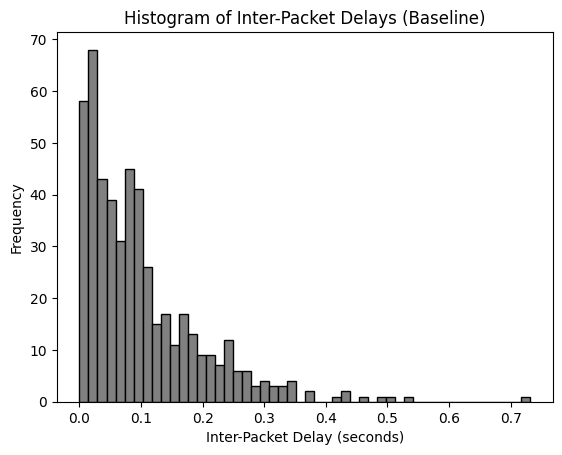

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'Data/Traffic_data_orig.csv'
data = pd.read_csv(file_path)

packet_times = data['Time'].tolist()

inter_packet_delays = []
for i in range(1, len(packet_times)):
    delay = packet_times[i] - packet_times[i - 1]
    inter_packet_delays.append(delay)

plt.hist(inter_packet_delays, bins=50, color='gray', edgecolor='black')

plt.xlabel('Inter-Packet Delay (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Inter-Packet Delays (Baseline)')

plt.show()

3. Include the histogram (jpeg or pdf). You run the above code. Save the histogram as a pdf of jpeg file and then load it in a new markdown cell below. 

<figure> 
    <img src="pics/3.png" width="800" height="600">
</figure>


### 4.3 A Simple Encoding Scheme

Alice and Bob decide to use the following encoding scheme to map the bits to the inter-packet delay. 

An inter-packet delay of 0.25 is used to encode a bit 0 

An inter-packet delay of 0.75 is used to encode a bit 1 


Write a Python code  that will generate the modified packet stream that contains the secret message.  Note that if $n$ is the number of secret bits you will need $n+1$ packets. Your code should generate a sequence of packets and their corresponding times and write in a file. Name the file Covert_Traffic_Data.csv. The file will contain 2 columns - packet number and the time. Assume first packet (P1) is sent at time 0. 

4. Include the code that generates the file Covert_Traffic_Data.csv in the new cell below. 

In [ ]:
secret_message = "0101"  

#Tính số lượng gói tin
num_packets = 0
for bit in secret_message:
    num_packets += 1
num_packets = num_packets + 1  

#  thời điểm gửi của các gói tin
packet_times = [0.0]  # Gói tin đầu tiên gửi lúc 0 giây
current_time = 0.0

for bit in secret_message:
    if bit == '0':
        current_time = current_time + 0.25  # Bit 0:  0.25 
    else:
        current_time = current_time + 0.75  # Bit 1:  0.75 
    packet_times.append(current_time)

# Tạo danh sách số thứ tự gói tin
packet_numbers = []
number = 1
while number <= num_packets:
    packet_numbers.append(number)
    number = number + 1

#  Ghi dữ liệu vào file CSV
file = open("Covert_Traffic_Data.csv", "w")
file.write("Packet number,Time\n")  # Ghi tiêu đề

for i in range(num_packets):
    packet_number = packet_numbers[i]
    time = packet_times[i]
    file.write(str(packet_number) + "," + str(time) + "\n")

file.close()  # Đóng file sau khi ghi xong

### 4.4 Histogram of Inter-packet Delays of the Covert Stream

We will now plot the histogram of the inter-packet delays of the covert packet stream, i.e., the histogram inter-packet delays from the packet stream  in the file Covert_Traffic_Data.csv.

5. Include the code that generates the histogram of the inter-packet delay from the data in the file Covert_Traffic_Data.csv. Put this code in a new code cell below. 

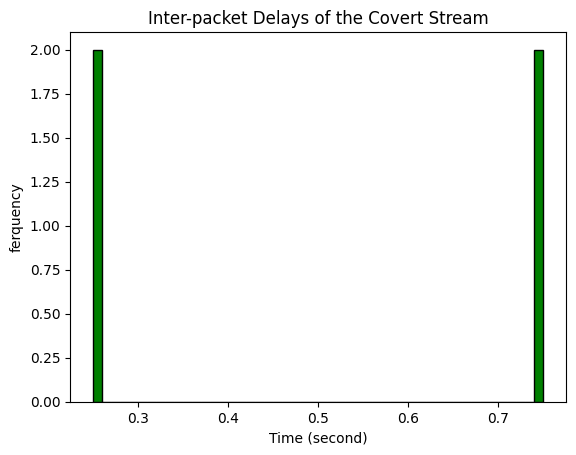

In [ ]:
import pandas as pd         
import matplotlib.pyplot as plt  

data = pd.read_csv('Covert_Traffic_Data.csv')
packet_times = data['Time'].tolist()
inter_packet_delays = []
for i in range(1, len(packet_times)):
    delay = packet_times[i] - packet_times[i - 1]
    inter_packet_delays.append(delay)
plt.hist(inter_packet_delays, bins=50, color='green', edgecolor='black')
plt.xlabel('Time (second)')  # Nhãn trục x
plt.ylabel('ferquency')                           # Nhãn trục y
plt.title('Inter-packet Delays of the Covert Stream')  # Tiêu đề
plt.show()

6. Include the histogram (jpeg or pdf) of the inter-packet delays in the new markdown cell below. 

<figure> 
    <img src="pics/6.png" width="800" height="600">
</figure>

 7. Eve will compare the histogram in 6 with that of 3. Will Eve be suspicious? Briefly explain why? Answer in a new markdown cell below. 

 Eve will notice when comparing the histogram from section 6 with the histogram from section 3 .
- Insection 3: This shows the normal distribution of inter-packet delays when Alice and Bob communicate without encoding secret messages.
- Insection 6 :This reflects the delays when Alice encodes a secret message, using 0.25 seconds for bit 0 and 0.75 seconds for bit 1.
-> the histogram's  delays will stand out as unusual. Eve will notice this difference.

### 4.5  A Better Modulation Scheme

Alice and Bob decide to use the following modulation scheme. 

Let $m$, $\min$, and $\max$ denote the median, min, and max of the inter-packet delay of the overt packet stream. 

1) If Alice needs to send a 0 she randomly generates a delay between $m$ and $\min$. 

2) If she want to send a 1 she randomly generates a delay between $m$ and $\max$. First, compute $m$, $\min$, and $\max$ of the overt packet stream. 


Next, modify the code  in  4.3, to generate  the covert  packet stream that contains  the secret message.

8. Include the code (in a new code cell below) that will that generates the Covert_Traffic_Data-V2.csv. 

In [ ]:
import random  # Để chọn số ngẫu nhiên

# Đọc file Traffic_data_origin.csv
file = open("Data/Traffic_data_orig.csv", "r")
lines = file.readlines()
file.close()

# Lấy thời điểm từ cột thứ hai
times = []
for line in lines[1:]:  # Bỏ qua dòng tiêu đề
    parts = line.split(",")
    time = float(parts[1])  # Chuyển thành số
    times.append(time)

# Tính khoảng thời gian
delays = []
for i in range(1, len(times)):
    delay = times[i] - times[i-1]
    delays.append(delay)

# Tính min
min_delay = delays[0]
for delay in delays:
    if delay < min_delay:
        min_delay = delay

# Tính max
max_delay = delays[0]
for delay in delays:
    if delay > max_delay:
        max_delay = delay

# Tính median
sorted_delays = sorted(delays)  # Sắp xếp danh sách
n = len(sorted_delays)
median_delay = sorted_delays[n // 2]  # Lấy giá trị giữa (giả sử n lẻ cho đơn giản)

# Thông điệp bí mật
secret_message = "0101"

# Tính số gói tin
num_packets = len(secret_message) + 1

# Tạo thời điểm gửi
packet_times = [0.0]  # Gói tin đầu tiên
current_time = 0.0
for bit in secret_message:
    if bit == '0':
        delay = random.uniform(min_delay, median_delay)  # Chọn ngẫu nhiên cho bit 0
    else:
        delay = random.uniform(median_delay, max_delay)  # Chọn ngẫu nhiên cho bit 1
    current_time = current_time + delay
    packet_times.append(current_time)

# Tạo số thứ tự
packet_numbers = []
for i in range(1, num_packets + 1):
    packet_numbers.append(i)

# Ghi vào file
file = open("Covert_Traffic_Data-V2.csv", "w")
file.write("Packet number,Time\n")  # Tiêu đề
for i in range(num_packets):
    file.write(str(packet_numbers[i]) + "," + str(packet_times[i]) + "\n")
file.close()

### 4.6 Histogram of Inter-packet Delays

Plot the histogram  of the inter-packet  delays of the overt packet stream and that of the new covert packet stream. Again, plot the histogram of the part of the packet stream that you need to encode the secret message. Do you think Eve will be suspicious?

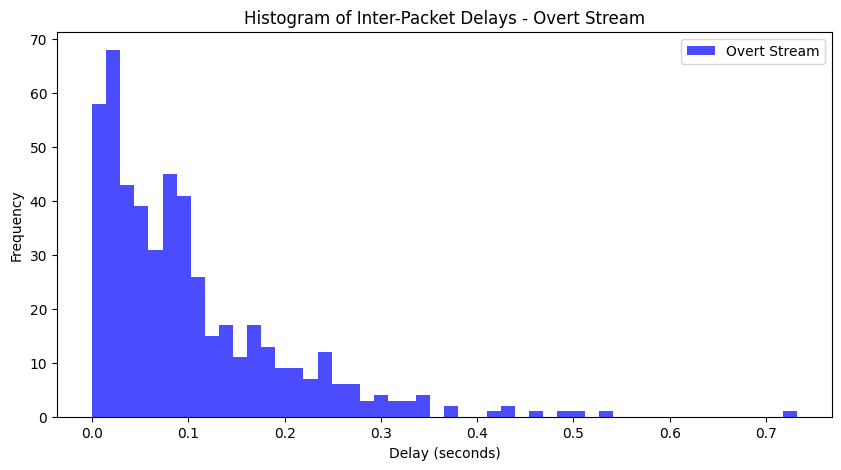

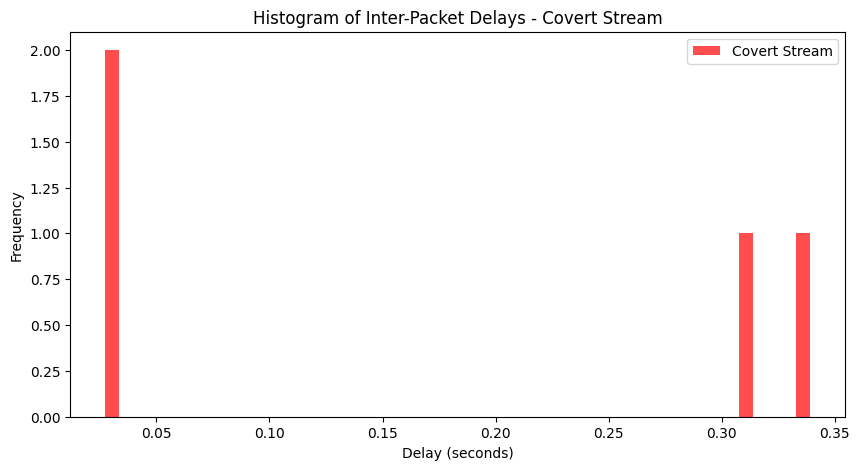

In [ ]:
#No Since the time intervals are now random and fall within a range similar to that of overt communication, the covert communication appears more natural.

import pandas as pd
import matplotlib.pyplot as plt

overt_data = pd.read_csv("Data/Traffic_data_orig.csv")
overt_times = overt_data['Time'].tolist()

covert_data = pd.read_csv("Covert_Traffic_Data-V2.csv")
covert_times = covert_data['Time'].tolist()

def calculate_delays(times):
    delays = []
    for i in range(1, len(times)):
        delay = times[i] - times[i - 1]
        delays.append(delay)
    return delays

overt_delays = calculate_delays(overt_times)
covert_delays = calculate_delays(covert_times)



# Plot histogram for overt delays
plt.figure(figsize=(10, 5))
plt.hist(overt_delays, bins=50, color='blue', alpha=0.7, label='Overt Stream')
plt.title('Histogram of Inter-Packet Delays - Overt Stream')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot histogram for full covert delays
plt.figure(figsize=(10, 5))
plt.hist(covert_delays, bins=50, color='red', alpha=0.7, label='Covert Stream')
plt.title('Histogram of Inter-Packet Delays - Covert Stream')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


9. Include the code that generates the histogram  of the inter-packet delays from Covert_Traffic_Data-V2.csv.  Put the code in a new code cell below. 

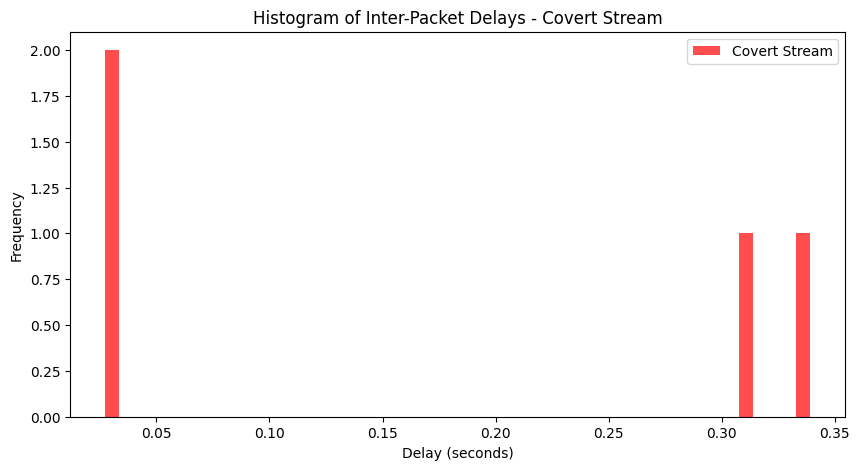

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

covert_data = pd.read_csv("Covert_Traffic_Data-V2.csv")
covert_times = covert_data['Time'].tolist()

def calculate_delays(times):
    delays = []
    for i in range(1, len(times)):
        delay = times[i] - times[i - 1]
        delays.append(delay)
    return delays

covert_delays = calculate_delays(covert_times)

# Plot histogram for full covert delays
plt.figure(figsize=(10, 5))
plt.hist(covert_delays, bins=50, color='red', alpha=0.7, label='Covert Stream')
plt.title('Histogram of Inter-Packet Delays - Covert Stream')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

10. Include the histogram (jpeg or pdf) of the inter-packet delays from the packet stream in the file Covert_Traffic_Data-V2.csv. Put the histogram in new markdown cell below. 

<figure> 
    <img src="pics/10.png" width="800" height="600">
</figure>

11. Is this new scheme better? Briefly explain why? Put your answer in a new markdown cell below. 

yes, Since the time intervals are now random and fall within a range similar to that of overt communication, the covert communication appears more natural. When plotting the histogram of these time intervals, we won't observe the two distinct peaks that were characteristic of the old method.

### 4.7 Propose and Evaluate Your Method 

For steps 12, 13, and 14, write your answer in a new markdown cell after each question. 


12. How can you improve upon the method in 4.5? Propose your scheme and plot the histogram of the covert packet stream. 

13. In this first simple scheme we have implicitly assumed the Alice will buffer up the required number of packets 
and release them  and we mentioned that it was unrealistic. Why?

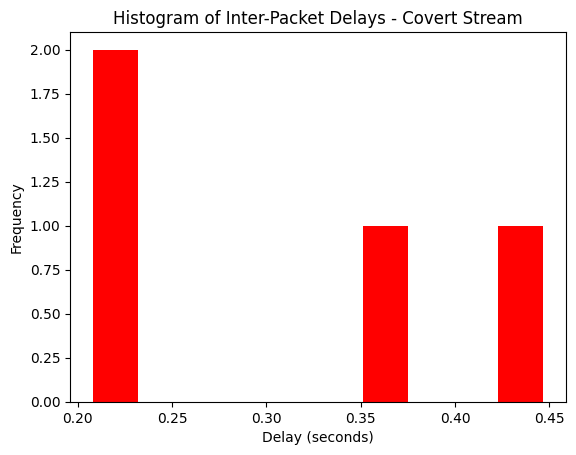

In [ ]:
# answer 12. To hide the message even more, we can make the secret delays look like normal traffic delays. Normal traffic has a pattern of delays that we can copy. (cdf)
# 1.Split the delay pattern into two parts: one for '0' and one for '1'.
# 2.For '0', pick a delay from the smaller half of the pattern. prefer value near min, minus random.uniform(0, 0.055)
# 3.For '1', pick a delay from the bigger half. prefer value near max, plus random.uniform(0, 0.055)
# 4 For delay add small value between (-0.011, 0.011)
import random
import matplotlib.pyplot as plt

min_delay = 0.1  # min
m_delay = 0.3    # median
max_delay = 0.5  # max

secret_message = "0101"

# Tạo danh sách khoảng thời gian
delays = []
for bit in secret_message:
    if bit == '0':
        # Chọn ngẫu nhiên từ min đến m, ưu tiên gần min
        delay = random.uniform(min_delay, m_delay)
        delay = delay - random.uniform(0, 0.055)  # Giảm nhẹ để gần min
    else:
        # Chọn ngẫu nhiên từ m đến max, ưu tiên gần max
        delay = random.uniform(m_delay, max_delay)
        delay = delay + random.uniform(0, 0.055)  # Tăng nhẹ để gần max
    # Thêm nhiễu nhỏ
    noise = random.uniform(-0.011, 0.011)
    delay += noise
    # Đảm bảo không vượt quá min và max
    delay = max(min_delay, min(delay, max_delay))
    delays.append(delay)

# Vẽ histogram
plt.hist(delays, bins=10, color='red')
plt.title('Histogram of Inter-Packet Delays - Covert Stream')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.show()

# answer 13.
# It’s not realistic to think that Alice can hold and send packets at exact times because real life has problems like:
#1 Internet changes can mess up the message.
#2 Computers and software have limits .
#3 Handling big messages needs a lot of computer power.

 14. We have assumed that the network does not alter the inter-packet delays. What would be the problem if it did? Can you suggest methods to mitigate the effect of the changes in the inter-packet delays (noise)?

In [ ]:
# answer 14. The receiver might see the wrong delay and mix up '0' for '1', ruining the message.
# 1.Send each '0' or '1' a few times. The receiver can guess the right one by picking what shows up most
# 2.send a test pattern that both Alice and Bob know. It helps the receiver stay on track

## 5. A Real Implementation

In this section, we make the implementation more realistics and address some engineering issues.  

### 5.1 Overview

In the previous part, we assumed that Alice buffers as many packets she requires to transmit the secret message. For eaxmple, if the secret message is 32 bits then Alice will buffer 33 packets and release the packets with appropriate delays based on the encoding scheme to encode the secret message. If the secret message is small, this will work as Alice needs to buffer a small number of packets. However, this will not work if the secret message is long as this will require Alice to buffer large number of packets and this is unealistic (you have found and written good reasons in answering the related question in 4.7 above). 


We will denote $m$ to be the size of the secret message. Also let $B$ denote the maximum number of packets that can be buffered at anytime. The issue of having a large $B$ is that packets that are at the end of the buffer  must wait for all the packets that in the front to be transmitted. This may cause unacceptable delays for the packets. The value of $B$ will be determined by the overt application that ALice is using. For example, for real-time application (such as Augmented Reality/Virtual Reality applications) $B$ will be small whereas for Email application $B$ can be large.   In this study we will consider different values of $m$ and $B$ with $m \geq B$ and Alice, Eve and Bob know the value of $B$ since they all know what is the overt application Alice is using. 

Given $m$ and $B$ what should be Alice's strategy be to tranmit the secret message? There are two important constraints: 

1. Alice cannot buffer more than $B$ packets because of the reason above.
2. Once she starts to transmit the secret message she cannot stop (because she has no way of letting Bob know). She must try to compelete sending the entire secret message.

Alice follows the following strategy. Before starting to transmit the secret message she buffers $i$ ($0 \geq i \leq B$) packets and then starts to release the packets to transmit the secret message. In order to determine what should $i$ be we need to discuss two system states that we need to worry about - buffer overflow and buffer underflow. Let's understand what these are, why these can occur and what are the factors that determine when they will occur. 


1. **Buffer Overflow**: This happens when the buffer already has $B$ packets and another packet arrives from the application. Recall we have said that the number of packets in the buffer cannot exceed $B$. To build  intuition as to when this happens let's consider a specific scenario. Suppose we have set $B = 10$, $m = 32$ and $i=8$. Since $i = 8$,  Alice will first buffer 8 packets. As soon as the 8th packet arrives from the application, she will start transmitting packets with inter-packet delays that encode the secret message.  While she release the packet from the buffer, new packets may arrive from the application that will be appended to the buffer. So the number of packets in the buffer will keep changing - decrease when a packet is transmitted and increase when a packet is generated by the application. Suppose at some time there 7 packets in the buffer and before the next packet is to be transmitted 4 packets arrive in quick succession from the application. This will cause the number of packets in the buffer to go beyond 10 and that will be a violation of policy at most 10 packets can be buffered. Essentially, if packets arrive faster than they are transmitted out, there will be buffer overflow. If $i$ is set close to $B$ there is likely to be an overflow. 


2. **Buffer Underflow**: This happens when a packet must be transmitted (to encode a bit of the secret message) but there are no packets in the buffer. Recall the constraint that once Alice starts to transmit the secret message she cannot stop. Hence, if packets arrive slower than they are transmitted there is likely  be buffer underflow. If $i$ is set close to 0, there is likely to be an underflow. 


**If either of the above two cases (buffer overflow and buffer underflow) arise during the process of sending the secret message we will consider that to be a failure of the covert channel. 


There are many factors that will determine if the covert channel will go into overflow and underflow. These include $m$, $B$, $i$, distribution of the inter-packet delay of the overt application, and the encoding scheme. In this part of the project we will write a simulation to study some of the above factors on the success of transmitting a secret message.  The overall sender-side system is shown in the Figure below. 


<figure> 
    <img src="Figures/ctc-implementation.jpg" width="600" height="400">
    <figcaption align = "center"><b>The overall system diagram of the source and the covert sender. </b></figcaption>
</figure>



### 5.2 Assumptions

  1. We will consider that the source generates packet following well-known IPD distributions. Specifically, we will consider two cases a) Exponential and b) Uniform. The sender (Alice) also knows this distribution and follows it to inject the delay between the packets to embed the secret message. It is important to note that the source and the sender are independent. Hence, even though they follow the same distribution,  the sequence of delays generated by the source will be different from the sequence of delays generated by the sender.
  
  2. To embed a 0, the sender generates a delay between the minimum value (min) and the median. To embed a 1 the sender generates a delay between the median value and the maximum value (max). Note that  for the Uniform distribution the min, max and median are easy to determine. For the Exponential distribution min is 0, the max is $\infty$. What is the median value of an Exponential distribution with rate parameter $\lambda$ pkts/sec?
  
  3. The secret message is a randomly generated sequence of 1s and 0s of size $m$ bits and is given. We will consider two values $m=16, 32$.
  
  4. The sender has a buffer of size $B$ and initially the sender buffers $i$ packets before starting to send the secret message.
  

### 5.3 Project Steps 

  1. For  buffer size $B=20$ we want to find out the probability of overflow  and  underflow, when the IPD follows the Exponential with $\lambda =1$ pkts/sec and $i=2, 6, 10, 14, 18$. Use message size $m = 16, 32$ bits. Tabulate the results. Remember that to determine the probability you need to run multiple (say 500) experiments for each parameter, i.e., for $B = 20, m = 16, i = 2$ run 500 experiments  and determine the probability of overflow and underflow. Similarly for other values of $i$ and $m$. The max value of an Exponential distribution is $\infty$. For this study  we can limit the max value to say 5 ~secs$. 
  
  2. For  buffer size $B=20$ we want to find out the probability of overflow  and  underflow, when the IPD follows the Uniform distribution in the range (0,1)  and $i=2, 6, 10, 14, 18$. Use message size $m = 16, 32$ bits.  Tabulate the results. Remember that to determine the probability you need to run multiple (say 500) experiments for each parameter, i.e., for $B = 20, m = 16, i = 2$ run 500 experiments  and determine the probability of overflow and underflow. Similarly for other values of $i$ and $m$.

  
  3. Propose methods to deal with buffer overflow and underflow.

### 5.4 Notes on Simulating the Implementation

For steps 1 and 2, since the source and the sender are independent processes, a proper way to simulate would be using a  discrete event simulation module such as simpy in Python.  However, we can simplify and just use standard Python. To do this,  we can pre-generate the times when the source generates packets and store it in a list. Then we can write the code to simulate the buffer, the encoding scheme, and  the sender. This can be done in a single "process." Based on this, following is a very **rough** set of steps to simulate the system.

For each experiment we can break it down to the following steps


 1. Generate the random bit pattern of 1s and 0s of size $m$ which is the secret message.

 2. Generate a sequence of times when the source will generate the packets. This is based inter-packet delay (IPD) distribution of the packets generate by the source. You can intuit what is the worst case number of packets that you need.

 3. For the buffer you need to keep some  variables such as B: buffer size, i: the initial buffer size to start sending he secret message bits and CB: current buffer size.

 4. For the sender you need to maintain some variables such as the time when the next packet will be sent.

 5. For each secret message bit:


       a. Generate a delay following the encoding scheme and hence determine when  the next packet will be transmitted.
       
       b. Update the state of the buffer depending on the number of arrivals during that time.
       
       c. At appropriate places check for buffer underflow and overflow and break out if it is the case.
       
       d. Appropriately update the current time.


  6. Do the experiment multiple times to calculate the different probabilities.
  

15. Include the code that you used to generate the results for Steps 1 and 2.  You should write only one code with the distribution of the inter-packet delays chosen as a parameter. Put your code in a new code cell below. 

In [2]:
import random

def generate_secret_message(m):
    message = []
    for _ in range(m):
        bit = random.randint(0, 1) 
        message.append(bit)
    return message
# mô phỏng thời điểm các gói tin đến trong một hệ thống
def generate_arrival_times(num_packets, distribution):
    times = [0]  
    # tao cac khoang tre
    for _ in range(num_packets - 1): 
        # khoảng trễ sẽ được sinh theo phân phối đồng nhất
        if distribution == "uniform":
            delay = random.uniform(0, 1) 
        elif distribution == "exponential":
            delay = random.expovariate(1)  
            if delay > 5:
                delay = 5 
        times.append(times[-1] + delay)  
    return times

def generate_transmission_delays(secret_msg, distribution):
    delays = []
    if distribution == "uniform":
        for bit in secret_msg:
            if bit == 0:
                delay = random.uniform(0, 0.5)  # Bit 0: 0 to 0.5 seconds
            else:
                delay = random.uniform(0.5, 1)  # Bit 1: 0.5 to 1 second
            delays.append(delay)
    elif distribution == "exponential":
        median = 0.693147 
        max_delay = 5
        for bit in secret_msg:
            if bit == 0:
                delay = random.uniform(0, median)  # Bit 0: 0 to median
            else:
                delay = random.uniform(median, max_delay)  # Bit 1: median to 5
            delays.append(delay)
    return delays

def simulate_experiment(m, B, i, distribution):
    # Số gói tin ban đầu trong bộ đệm là i
    arrival_times = generate_arrival_times(1000, distribution)
    t_start = arrival_times[i - 1] 
    
    secret_msg = generate_secret_message(m)
    delays = generate_transmission_delays(secret_msg, distribution)
    
    transmission_times = [t_start]
    current_time = t_start
    for delay in delays:
        current_time += delay
        transmission_times.append(current_time)
    
    tm = transmission_times[-1]
    # lay gia tri cuoi cung
    events = []
    for t in arrival_times:
        if t <= tm:
            events.append((t, "arrival"))
    for t in transmission_times:
        events.append((t, "transmission"))
    events.sort()  
    
    buffer_size = 0
    overflow = False
    underflow = False
    for time, event_type in events:
        if event_type == "arrival":
            buffer_size += 1 
            if buffer_size > B:
                overflow = True  
                break
        elif event_type == "transmission":
            if buffer_size == 0:
                underflow = True  
                break
            buffer_size -= 1  
    return overflow, underflow

# Function to run many simulations and find probabilities
def run_experiments(m, B, i, distribution, num_experiments=500):
    overflow_count = 0
    underflow_count = 0
    for _ in range(num_experiments):
        overflow, underflow = simulate_experiment(m, B, i, distribution)
        if overflow:
            overflow_count += 1
        if underflow:
            underflow_count += 1
    # Calculate chances of each outcome
    prob_overflow = overflow_count / num_experiments
    prob_underflow = underflow_count / num_experiments
    prob_success = 1 - (prob_overflow + prob_underflow)
    return prob_underflow, prob_overflow, prob_success


B = 20  
distributions = ["uniform", "exponential"] 
m_values = [16, 32] 
i_values = [2, 6, 10, 14, 18]

for distribution in distributions:
    print(f"Source Distribution = {distribution.capitalize()}")
    print("M Size\t i\t Underflow\t Overflow\t Success")
    for m in m_values:
        for i in i_values:
            underflow, overflow, success = run_experiments(m, B, i, distribution)
            print(f"{m}\t {i}\t {underflow:.3f}\t\t {overflow:.3f}\t\t {success:.3f}")
    print()  

Source Distribution = Uniform
M Size	 i	 Underflow	 Overflow	 Success
16	 2	 0.646		 0.000		 0.354
16	 6	 0.076		 0.000		 0.924
16	 10	 0.000		 0.000		 1.000
16	 14	 0.000		 0.048		 0.952
16	 18	 0.000		 0.302		 0.698
32	 2	 0.746		 0.002		 0.252
32	 6	 0.212		 0.002		 0.786
32	 10	 0.024		 0.018		 0.958
32	 14	 0.000		 0.116		 0.884
32	 18	 0.000		 0.490		 0.510

Source Distribution = Exponential
M Size	 i	 Underflow	 Overflow	 Success
16	 2	 0.398		 0.104		 0.498
16	 6	 0.042		 0.290		 0.668
16	 10	 0.006		 0.510		 0.484
16	 14	 0.000		 0.722		 0.278
16	 18	 0.000		 0.890		 0.110
32	 2	 0.408		 0.414		 0.178
32	 6	 0.066		 0.744		 0.190
32	 10	 0.010		 0.810		 0.180
32	 14	 0.000		 0.938		 0.062
32	 18	 0.000		 0.964		 0.036



16. Table of results here for Step 1 (IPDs follow Exponential Distribution). Put the table in a new Markdown cell below. 

In [ ]:
# Source Distribution = Exponential
# M Size	 i	 Underflow	 Overflow	 Success
# 16	 2	 0.394	        0.148	 0.458
# 16	 6	 0.046	        0.292	 0.662
# 16	 10	 0.006	        0.514	 0.480
# 16	 14	 0.000	        0.714	 0.286
# 16	 18	 0.000	        0.918	 0.082
# 32	 2	 0.372	        0.420	 0.208
# 32	 6	 0.048	        0.752	 0.200
# 32	 10	 0.010	        0.860	 0.130
# 32	 14	 0.000	        0.920	 0.080
# 32	 18	 0.000	        0.980	 0.020

17. Table of results here for Step 2. (IPDs follow Uniform Distribution). Put the table in a new Markdown cell below. 

In [ ]:
# Source Distribution = Uniform
# M Size	 i	 Underflow	 Overflow	 Success
# 16	 2	 0.648		 0.000		 0.352
# 16	 6	 0.054		 0.000		 0.946
# 16	 10	 0.000		 0.000		 1.000
# 16	 14	 0.000		 0.040		 0.960
# 16	 18	 0.000		 0.310		 0.690
# 32	 2	 0.716		 0.000		 0.284
# 32	 6	 0.248		 0.000		 0.752
# 32	 10	 0.036		 0.024		 0.940
# 32	 14	 0.000		 0.170		 0.830
# 32	 18	 0.000		 0.464		 0.536

Sample Results for Steps 1 and 2. 

Source Distribution = Exponential
M Size      i             Underflow         Overflow      Success  
16           2             0.382              0.134        0.484    
16           6             0.058              0.294        0.648    
16           10            0.006              0.524        0.470    
16           14            0.000              0.710        0.290    
16           18            0.000              0.876        0.124    
32           2             0.404              0.400        0.196    
32           6             0.062              0.664        0.274    
32           10            0.014              0.830        0.156    
32           14            0.000              0.906        0.094    
32           18            0.000              0.958        0.042    



Source Distribution = Uniform
M Size      i             Underflow         Overflow      Success  
16           2             0.652              0.000        0.348    
16           6             0.080              0.000        0.920    
16           10            0.000              0.000        1.000    
16           14            0.000              0.040        0.960    
16           18            0.000              0.330        0.670    
32           2             0.772              0.000        0.228    
32           6             0.238              0.004        0.758    
32           10            0.024              0.022        0.954    
32           14            0.002              0.158        0.840    
32           18            0.000              0.460        0.540 

18. Can you propose one scheme to deal with buffer overflows and underflows? Write you answer in a new markdown cell below. 


We can use a system to monitor and adjust the amount of data based on the state of the buffer. For example, to prevent buffer overflow: when the buffer is almost full (80%), reduce or pause adding new data to avoid overflow. And to prevent buffer underflow: when the buffer is almost empty (e.g., 5% remaining), increase the amount of data input to avoid underflow.

19. Give a version of the code that I can run for different values of the parameters, namely, a) inter-packet delay distribution (Uniform or Exponential), 2) size of the secret message and 3) value of $i$. Name the file "real_implementation_code.py."  Your code should ask for the three inputs and output the Underflow, Overflow, and Success probabilities. 

Write how to run the code in the new markdown cell below.  

In [ ]:
# plane A
# 1. win + r type cmd to open terminal 
# 2. direct to real_implementation_code.py locate
# 3. type python real_implementation_code.py to run 
# python version Python 3.11.9

Probability  Underflow: 0.406
Probability Overflow: 0.120
Probability success: 0.474


## 6 Detection 

In this section we will investigate some simple appropaches to detect timimng channels. This is the task of Eve. 

As mentioned in Section 4.2,  we assume that Eve has a packet stream that is "clean" i.e., it is not modified by a timing channel. Eve can derive many features from this packet stream. One that we have focussed in Section 4.2 is the distribution of the inter-packet delay. (You may reflect on what other fetaures you could consider.)

Given the baseline inter-packet delay distribution, what Eve will do is the following 

1. Take a sample of the packet stream when Alice and Bob talk
2. Extract the inter-packet delay distribution
3. Compare with the baseline 
4. Flag if the distributions are different

There are many engineering issues with each of the above steps but here we will focus on Steps 3 and 4. The basic problem is the following. We have two sets of inter-packet delay samples. We want to know if they are from the same distribution. You can guess that this must be common problem and there must be many different approaches. Yes there are many methods. There are qualitative approcheas such as l comparing the boxplots, the cummulative distribution finctions, the histograms, the Q-Q plot, and the Kernel density functions. There are quantitative statistical test such the T-test, Mann–Whitney U Test, the Kolmogorov–Smirnov test, among others.  For this project we will focus on the Q-Q plot. 

### 6.1 Q-Q Plot

In Q-Q plot \[Q stands for quantile\], the quantiles of the two distributions are plotted against each other. If the distributions are the same, we should get a 45-degree line.

We will use two Python modules numpy and statsmodels.  You must install these modules either using pip3 or  conda. 

The basic function is qqplot. It by default plots quantiles with respect to quantiles of the standard normal (Z) distribution. 


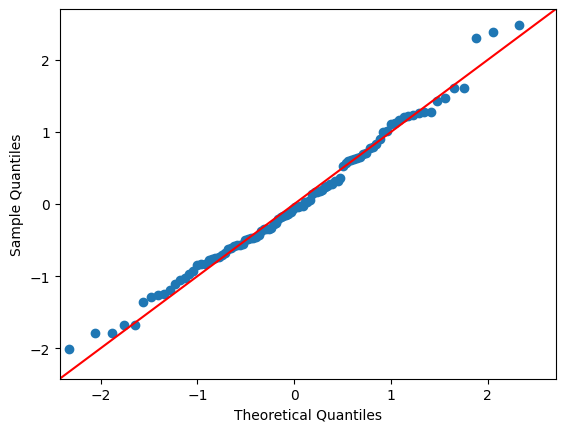

In [12]:
import numpy as np
import statsmodels.api as sm
import pylab as py
  
# Generate 100 samples from a standard normal (Z) distribution
sample_data1 = np.random.normal(0, 1, 100)
sm.qqplot(sample_data1, line ='45')

py.show()

\[ I have not figured out how to resolve the warning. If someone does, please let me know\]

In the above code see what happens when you increase the number of samples to 1000 and then to 10000. 

Next we generate sample from an Exponential distribution  with rate $\lambda =1 $  and get the Q-Q plot. 

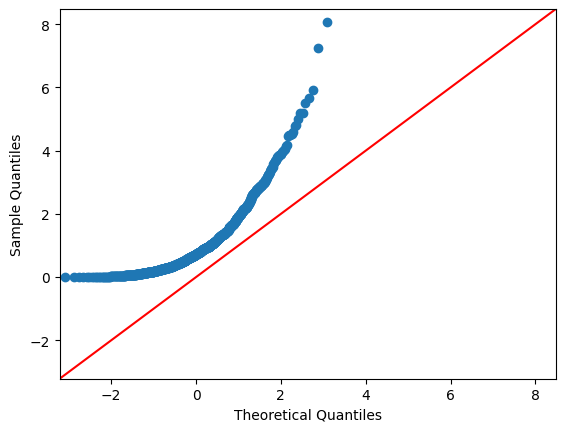

In [18]:

# Generate 100 samples from an exponential distribution with rate $\lambda =1 $
sample_data1 = np.random.exponential(1, 1000)
sm.qqplot(sample_data1, line ='45')
py.show()

### 6.2 Q-Q Plot with 2 Samples 

qqplot_2samples gives the Q-Q plots for the quantiles derived from two data sets. We will consider the size of both samples to be the same althougth it is not required. In the following code see what happens as you increase the number of samples

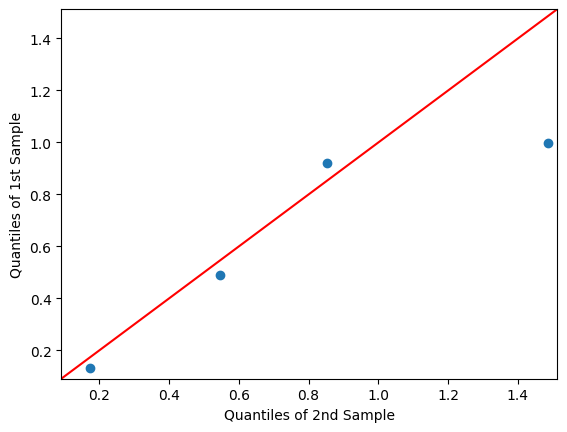

In [48]:

# Generate 100 samples from an exponential distribution with rate $\lambda =1 $
sample_data1 = np.random.exponential(1, 4)
# Generate another 100 samples from the  exponential distribution with rate $\lambda =1 $
sample_data2 = np.random.exponential(1, 100)
sm.qqplot_2samples(sample_data1, sample_data2, line ='45')
py.show()

### 6.3 A Simple Task

For this project, using the qqplot_2samples, get the Q-Q plot of the inter-packet delays generated in Section 4.5 with that of the baseline. Use only the inter-packet delays that contain the the secret message. Use the same number of inter-packet delays from the baseline traffic. 

22. Include the code and that will generate the plot in a cell below. 

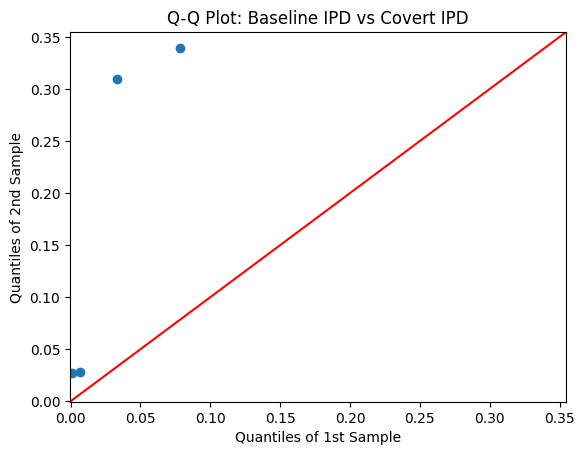

In [44]:
import numpy as np
import statsmodels.api as sm
import pylab as py
import pandas as pd

# Load the baseline (overt) and modified (covert) data
overt_data = pd.read_csv("Data/Traffic_data_orig.csv")
covert_data = pd.read_csv("Covert_Traffic_Data-V2.csv")

# Extract timestamps from the 'Time' column
overt_times = overt_data['Time'].tolist()
covert_times = covert_data['Time'].tolist()

# Function to calculate inter-packet delays
def calculate_delays(times):
    delays = []
    for i in range(1, len(times)):
        delay = times[i] - times[i - 1]
        delays.append(delay)
    return delays

# Calculate IPD for both streams
overt_delays = calculate_delays(overt_times)
covert_delays = calculate_delays(covert_times)

# Ensure equal sample sizes by truncating to the minimum length
min_samples = min(len(overt_delays), len(covert_delays))
overt_delays = np.asarray(overt_delays[:min_samples])
covert_delays = np.asarray(covert_delays[:min_samples])

# Generate and display the Q-Q plot
sm.qqplot_2samples(overt_delays, covert_delays, line='45')
py.title("Q-Q Plot: Baseline IPD vs Covert IPD")
py.show()

23. Include the plot (pdf, jpeg, or png) in a new markdown cell below. 

<figure> 
    <img src="pics/23.png" width="800" height="600">
</figure>

24. Propose a different approach to compare two distributions. An existing statistical method is OK. 
Describe it and use it  compare the baseline with your proposed method in Section 4.7. 

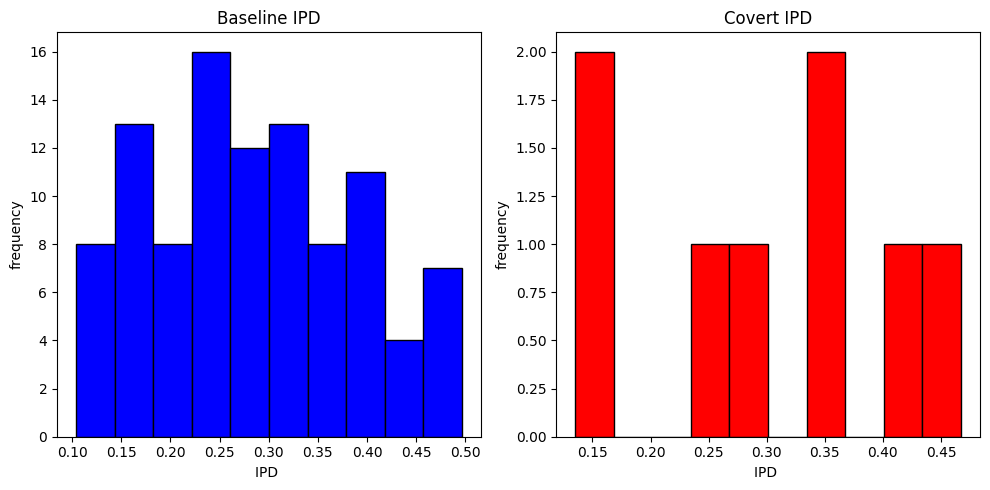

In [ ]:
# Draw a histogram for the baseline IPD, which represents the distribution of the original data, 
# and another for the covert IPD, which represents the distribution of the adjusted data.
#  If the two histograms look similar, with bars of comparable heights, 
# it suggests that the two distributions are similar. If the histograms differ significantly, 
# it indicates that the distributions are different.

import matplotlib.pyplot as plt
import numpy as np
import random

# Giả lập IPD cơ sở: 100 giá trị ngẫu nhiên từ 0.1 đến 0.5
baseline_delays = np.random.uniform(0.1, 0.5, 100)

# Giả lập IPD bí mật: điều chỉnh theo bit '0' và '1'
min_delay = 0.1
m_delay = 0.3
max_delay = 0.5
secret_message = "01010101"
covert_delays = []
for bit in secret_message:
    if bit == '0':
        delay = random.uniform(min_delay, m_delay)
    else:
        delay = random.uniform(m_delay, max_delay)
    noise = random.uniform(-0.01, 0.01)  # Thêm nhiễu nhỏ
    delay += noise
    covert_delays.append(delay)

# Vẽ histogram
plt.figure(figsize=(10, 5))

# Histogram cho IPD cơ sở
plt.subplot(1, 2, 1)
plt.hist(baseline_delays, bins=10, color='blue', edgecolor='black')
plt.title('Baseline IPD')
plt.xlabel('IPD ')
plt.ylabel('frequency')

# Histogram cho IPD bí mật
plt.subplot(1, 2, 2)
plt.hist(covert_delays, bins=10, color='red', edgecolor='black')
plt.title('Covert IPD')
plt.xlabel('IPD ')
plt.ylabel('frequency')

plt.tight_layout()
plt.show()

## 7 Finishing up

24. If you have a partner for this project, please put the names of the team members (i.e., both the names if you worked in a team of 2) in new markdown cell below.

Nguyen Khoa Tran 

25. Please provide  feedback about the project, specifically, how it can be improved.  Please put your comments in a new markdown cell below. 

need to specific about the serect message like need to generate "abcdef" to binary

### Submission and Grading Guidelines 

1. For this project  there is one input file and input figures (the drawings). You will write code  which will generate results, figures, and files. 

2. Put this jupyter notebook, the input file, input figures, the new figures and files you generate in one folder. Make sure that paths are set properly so that the figures will render when I open the notebook. 

3. For Step 18,  you need to include a version of the code that I can run by changing the parameters. See Step 18 for details. 

4. Submit a zipfile of the folder. 

5. If you are working in a team, each member of the team must submit the same zip file. 

6. There may be interactive grading. 